# Assignment

## Importing Libraries

In [93]:
import numpy as np
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the Datasets

In [94]:
cifar_dataset_train = datasets.CIFAR10(root='./data',train=True,download=True,transform=transforms.Compose([transforms.ToTensor(),transforms.Resize(227)]))

cifar_dataset_test = datasets.CIFAR10(root='./data',train=False,download=True,transform=transforms.Compose([transforms.ToTensor(),transforms.Resize(227)]))

Files already downloaded and verified
Files already downloaded and verified


## Creating the training dataset

In [95]:
from torch.utils.data import DataLoader
batch_size = 100

train_iter = DataLoader(cifar_dataset_train,batch_size,shuffle=True)

In [96]:
X,y = next(iter(train_iter))

C:\Users\ifeda\PycharmProjects\Convolutional Neural Networks\venv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


## Creating the test dataset

In [97]:
test_iter = DataLoader(cifar_dataset_test,batch_size,shuffle=True)

In [98]:
X_test,y_test = next(iter(test_iter))

## Analysing the CIFAR-10 data

In [99]:
print(f'The dimensions of each input image is {X.size()} The number of input channels is {X.size()[1]}')
print(f'The output labels are as follows {y}')

The dimensions of each input image is torch.Size([100, 3, 227, 227]) The number of input channels is 3
The output labels are as follows tensor([6, 9, 7, 2, 3, 5, 2, 6, 0, 2, 2, 5, 9, 2, 3, 5, 5, 0, 6, 6, 9, 4, 0, 8,
        7, 9, 0, 5, 9, 6, 0, 9, 5, 6, 2, 8, 9, 0, 6, 2, 3, 2, 5, 7, 0, 3, 0, 1,
        4, 2, 7, 6, 4, 7, 9, 5, 0, 8, 2, 7, 4, 9, 8, 0, 0, 1, 3, 8, 7, 3, 3, 2,
        1, 8, 0, 7, 4, 3, 3, 7, 1, 1, 6, 9, 4, 3, 0, 7, 7, 3, 5, 7, 5, 2, 6, 4,
        2, 4, 8, 8])


## Example image

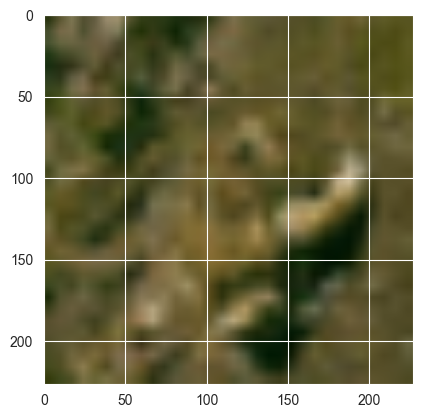

In [101]:
plt.imshow(X[0].T)

## CNN Architecture

In [149]:
class CNN(torch.nn.Module):
    def __init__(self,num_channels,num_outputs):
        super(CNN,self).__init__()
        self.num_channels = num_channels
        self.num_outputs = num_outputs

        #Spatial/Global Pooling for input-------------------------------------------------------
        self.spatial_avg_pool1 = torch.nn.AdaptiveAvgPool2d((12,12))

        # Design the base block Element---------------------------------------------------------
        #Create an input linear layer for future combination
        self.initial_block_linear = torch.nn.Sequential(
            torch.nn.Linear(in_features=43200,out_features=2),
            torch.nn.ReLU()
        )

        self.initial_block_conv = torch.nn.Sequential(
            torch.nn.Conv2d(num_channels,out_channels=8,kernel_size=3,stride=1,padding=1),
            torch.nn.BatchNorm2d(8),
            torch.nn.ReLU()

        )

        self.second_block_conv = torch.nn.Sequential(
            torch.nn.Conv2d(num_channels,out_channels=12,kernel_size=4,stride=1,padding=2),
            torch.nn.BatchNorm2d(12),
            torch.nn.ReLU()
        )

        # Create the spatial average pooling layer for the inputs to the dense---------------------
        self.spatial_avg_pool2 = torch.nn.AdaptiveAvgPool1d(9216)

        # Create the dense,classification block----------------------------------------------------
        # First FC linear layer
        self.initial_fc = torch.nn.Sequential(
            torch.nn.Dropout(0),
            torch.nn.Linear(in_features=9216,out_features=4096),
            torch.nn.ReLU()
        )

        # Create the final layer leading into softmax
        self.final_fc = torch.nn.Sequential(
            torch.nn.Dropout(0),
            torch.nn.Linear(in_features=4096,out_features=num_outputs),
            torch.nn.ReLU(),
            torch.nn.Softmax(dim=1)
        )

    def forward(self,x):
        # Applying average pooling to down sample the image from 32 -> 24
        a = self.spatial_avg_pool1(x)

        # First Block------------------------------------------------------
        #Reshape the tensor to allow for matrix multiplication
        a = torch.flatten(a)
        a = self.initial_block_linear(a)

        # Get outputs of each convolution ->RelU layer
        o1 = self.initial_block_conv(x)
        o2 = self.second_block_conv(x)

        O = torch.concat((o1.view(100,-1),o2.view(100,-1)),dim=1)

        # Prepare the outputs for the second block
        O = torch.matmul(a,O.view(2,-1))

        # Apply spatial pooling before entering the dense layer------------
        O_bn = self.spatial_avg_pool2(O.view(100,-1))

        # Move to the dense/classification block
        output = self.initial_fc(O_bn.view(100,-1))

        output = self.final_fc(output)

        return output

In [147]:
model = CNN(num_channels=3,num_outputs=10)
print(model)

CNN(
  (spatial_avg_pool1): AdaptiveAvgPool2d(output_size=(12, 12))
  (initial_block_linear): Sequential(
    (0): Linear(in_features=43200, out_features=2, bias=True)
    (1): ReLU()
  )
  (initial_block_conv): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (second_block_conv): Sequential(
    (0): Conv2d(3, 12, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (spatial_avg_pool2): AdaptiveAvgPool1d(output_size=128598)
  (initial_fc): Sequential(
    (0): Dropout(p=0, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU()
  )
  (final_fc): Sequential(
    (0): Dropout(p=0, inplace=False)
    (1): Linear(in_features=4096, out_features=10, bias=True)
    (2): ReLU()
    (3): Softmax(dim=1)
  

In [148]:
model(X).size()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x128598 and 9216x4096)

## Create the metric for calculating accuracy

In [142]:
def accuracy(y_hat,y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
        cmp = (y_hat.type(y.dtype) == y)
        return float(torch.sum(cmp))

## Create the model training system

In [143]:
def train_model(model,X,y,X_test,y_test,accuracy,epochs):

    # Create the loss component
    loss = torch.nn.CrossEntropyLoss()

    # Create the optimizer term
    optimizer = torch.optim.SGD(model.parameters(), lr=0.005,weight_decay=0.005,momentum=0.9)

    score_train = []
    score_test = []
    l_score = []

    for epoch in range(0,epochs):
        model.train()
        y_hat = model(X)
        l = loss(y_hat,y)

        optimizer.zero_grad()

        l.backward()
        optimizer.step()

        # Training Accuracy
        score_train.append(accuracy(model(X),y)/len(y))

        # Loss graph
        l_score.append(l.item())

        # # Test Accuracy
        # torch.no_grad()
        # model.eval()
        # score_test.append(accuracy(model(X_test),y_test)/len(y_test))

    return score_train,l_score

In [144]:
epochs = 30
s1,loss = train_model(model,X,y,X_test,y_test,accuracy,epochs)

In [145]:
s1

[0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.08,
 0.08,
 0.08,
 0.08,
 0.08,
 0.08,
 0.1]

Text(0, 0.5, 'Accuracy')

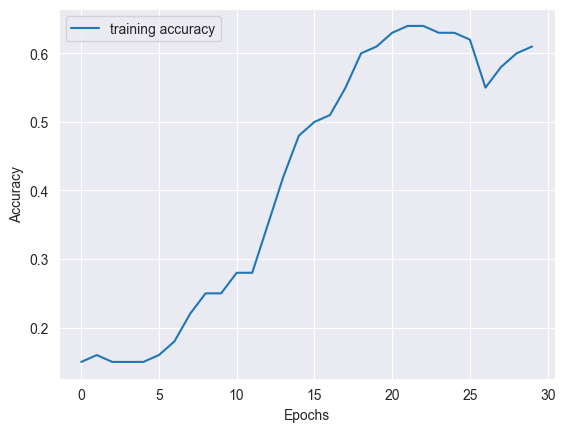

In [137]:
sns.lineplot(x=range(0,epochs),y=s1,label='training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

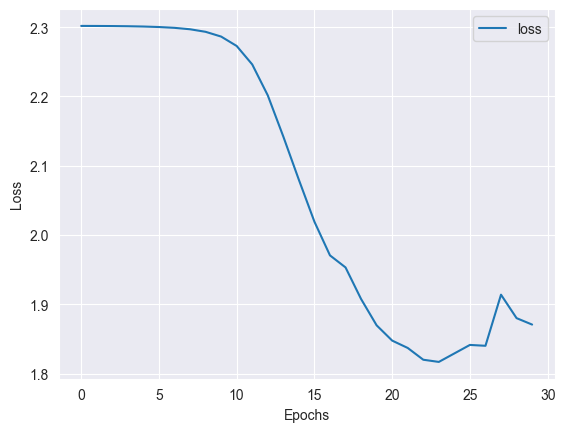

In [138]:
sns.lineplot(x=range(0,epochs),y=loss,label='loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [125]:
#model(X)

tensor([[7.3181e-14, 2.0862e-19, 7.1874e-07, 1.5001e-11, 1.9226e-20, 2.7919e-11,
         1.0000e+00, 1.9226e-20, 1.9226e-20, 1.9226e-20],
        [1.0000e+00, 9.8657e-13, 5.2408e-14, 5.5230e-13, 1.9192e-32, 1.1071e-25,
         3.9453e-26, 1.9192e-32, 1.9192e-32, 1.9192e-32],
        [1.0000e+00, 5.9227e-37, 8.2888e-20, 7.5893e-14, 7.6612e-39, 3.1575e-37,
         1.3415e-20, 7.6612e-39, 1.2157e-38, 7.6612e-39],
        [3.8719e-29, 2.4527e-29, 1.0000e+00, 4.6595e-34, 8.1742e-41, 6.2337e-19,
         2.5557e-40, 8.1742e-41, 8.1742e-41, 8.1742e-41],
        [2.4137e-14, 2.0003e-15, 3.2463e-16, 1.0000e+00, 1.5695e-24, 7.6439e-22,
         1.5048e-20, 1.5695e-24, 1.5695e-24, 1.5587e-22],
        [3.7464e-30, 3.7464e-30, 3.5487e-22, 3.7464e-30, 3.7464e-30, 1.0000e+00,
         3.5856e-28, 3.7464e-30, 3.7464e-30, 2.8732e-13],
        [4.6517e-32, 5.1616e-31, 1.0000e+00, 3.9121e-28, 3.9768e-32, 4.6723e-26,
         9.0889e-23, 3.9768e-32, 3.9768e-32, 3.9768e-32],
        [5.1857e-09, 1.7021